In [1]:
!pip install -q kagglehub lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 21.3 MB/s eta 0:00:00


In [2]:
import os
import glob
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as T
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import kagglehub
import shutil
from torchvision import transforms
from tqdm import tqdm
from torch import optim

In [3]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
cache_path = kagglehub.dataset_download("andrewmvd/drive-digital-retinal-images-for-vessel-extraction")
target_dir = "./drive_data"
if os.path.exists(target_dir):
     shutil.rmtree(target_dir)
shutil.copytree(cache_path, target_dir)
print("Датасет сохранен в:", target_dir)

100%|██████████| 28.0M/28.0M [00:00<00:00, 107MB/s]

Extracting files...


Датасет сохранен в: ./drive_data


In [5]:
DRIVE_DIR = os.path.join(target_dir, "DRIVE")
TRAIN_IMG_DIR = os.path.join(DRIVE_DIR, "training/images")
TRAIN_MASK_DIR = os.path.join(DRIVE_DIR, "training/1st_manual") # размеченные экспертами бинарные маски сосудов
TRAIN_FOV_DIR = os.path.join(DRIVE_DIR, "training/mask") # область (круг), в пределах которой рассмтаривается снимок

TEST_IMG_DIR = os.path.join(DRIVE_DIR, "test/images")
TEST_FOV_DIR = os.path.join(DRIVE_DIR, "test/mask")

In [29]:
def load_train_images(img_dir, mask_dir, fov_dir):
    img_files = sorted(glob.glob(os.path.join(img_dir, '*.tif')))
    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.gif')))
    fov_files = sorted(glob.glob(os.path.join(fov_dir, '*.gif')))

    images, masks, fov_masks = [], [], []
    for img_path, mask_path, fov_path in zip(img_files, mask_files, fov_files):
        img = Image.open(img_path).convert("RGB")
        img = np.array(img, dtype=np.float32) / 255.0
        images.append(img)

        mask = Image.open(mask_path)
        mask = np.array(mask, dtype=np.float32)
        mask[mask>0] = 1.0
        mask = np.expand_dims(mask, axis=-1)
        masks.append(mask)

        fov = Image.open(fov_path)
        fov = np.array(fov, dtype=np.float32)
        fov[fov > 0] = 1.0
        fov = np.expand_dims(fov, axis=-1)
        fov_masks.append(fov)

    return np.array(images), np.array(masks), np.array(fov_masks)
def load_test_images(img_dir, mask_dir):
    img_files = sorted(glob.glob(os.path.join(img_dir, '*.tif')))
    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.gif')))

    images, masks = [], []
    for img_path, mask_path in zip(img_files, mask_files):
        img = Image.open(img_path).convert("RGB")
        img = np.array(img, dtype=np.float32) / 255.0
        images.append(img)

        mask = Image.open(mask_path)
        mask = np.array(mask, dtype=np.float32)
        mask[mask>0] = 1.0
        mask = np.expand_dims(mask, axis=-1)
        masks.append(mask)

    return np.array(images), np.array(masks)
images, masks, fov_masks = load_train_images(TRAIN_IMG_DIR, TRAIN_MASK_DIR, TRAIN_FOV_DIR)
test_images, test_fov_masks = load_test_images(TEST_IMG_DIR, TEST_FOV_DIR)
print("Number of train images:", len(images))
print("Number of test images:", len(test_images))

Number of train images: 20
Number of test images: 20


In [30]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    # Геометрические трансформации
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),  # небольшой рандомный поворот
    # Эластичная деформация
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.3),

    # Цветовые аугментации (только на изображении, не на маске)
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),

    # Приведение к тензору
    ToTensorV2()
], additional_targets={'mask': 'mask'})

/tmp/ipython-input-542362998.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.3),


In [60]:
# Эта функция должна быть определена, чтобы следующие ячейки работали
def reconstruct_from_patches(patches, original_img_shape, stride=64):
    """
    Собирает полную маску из патчей с правильным усреднением перекрытий.
    """
    img_h, img_w = original_img_shape[0], original_img_shape[1]
    patch_size = patches.shape[1] # [N, H, W, C] -> H

    if patches.ndim == 3:
        patches = np.expand_dims(patches, axis=-1) # [N, H, W] -> [N, H, W, 1]

    reconstructed_img = np.zeros((img_h, img_w, 1), dtype=np.float32)
    count_matrix = np.zeros((img_h, img_w, 1), dtype=np.float32)

    patch_idx = 0
    for y in range(0, img_h - patch_size + 1, stride):
        for x in range(0, img_w - patch_size + 1, stride):
            if patch_idx < len(patches):
                reconstructed_img[y:y+patch_size, x:x+patch_size] += patches[patch_idx]
                count_matrix[y:y+patch_size, x:x+patch_size] += 1
                patch_idx += 1

    count_matrix[count_matrix == 0] = 1
    reconstructed_img /= count_matrix

    return reconstructed_img
class PatchDataset(Dataset):
    def __init__(self, images, masks, fovs=None, patch_size=128, stride=64, transform=None):
        """
        images, masks: списки полных изображений и масок
        fovs: список FOV-масок тех же размеров, что и images
        """
        self.images = images
        self.masks = masks
        self.fovs = fovs
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.patches_per_image = []
        self.full_image_shapes = []
        self.all_patches = []
        self.all_patches_masks = []
        self.all_patches_fovs = []

        for idx, (img, mask) in enumerate(zip(images, masks)):
            img_h, img_w = img.shape[:2]
            self.full_image_shapes.append((img_h, img_w))
            patches_img, patches_mask, patches_fov = [], [], []
            fov = None if fovs is None else fovs[idx]

            for y in range(0, img_h - patch_size + 1, stride):
                for x in range(0, img_w - patch_size + 1, stride):
                    patches_img.append(img[y:y+patch_size, x:x+patch_size])
                    patches_mask.append(mask[y:y+patch_size, x:x+patch_size])
                    if fov is not None:
                        patches_fov.append(fov[y:y+patch_size, x:x+patch_size])

            self.patches_per_image.append(len(patches_img))
            self.all_patches.extend(patches_img)
            self.all_patches_masks.extend(patches_mask)
            if fov is not None:
                self.all_patches_fovs.extend(patches_fov)

    def __len__(self):
        return len(self.all_patches)

    def __getitem__(self, idx):
        img = self.all_patches[idx]
        mask = self.all_patches_masks[idx]
        fov = None if not self.all_patches_fovs else self.all_patches_fovs[idx]

        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img, mask = transformed["image"], transformed["mask"]

        # Приводим маску к форме [1, H, W]
        if mask.ndim == 2:
            mask = mask.unsqueeze(0)
        elif mask.ndim == 3 and mask.shape[-1] == 1:
            mask = mask.permute(2, 0, 1)

        # То же для FOV
        if fov is not None:
            if fov.ndim == 2:
                fov = torch.tensor(fov, dtype=torch.float32).unsqueeze(0)
            elif fov.ndim == 3 and fov.shape[-1] == 1:
                fov = torch.tensor(fov, dtype=torch.float32).permute(2, 0, 1)

        if fov is not None:
            return img, mask, fov
        else:
            return img, mask

    def get_full_mask(self, img_idx):
        patches = self.all_patches_masks[
            sum(self.patches_per_image[:img_idx]) : sum(self.patches_per_image[:img_idx+1])
        ]
        return reconstruct_from_patches(np.stack(patches, axis=0), self.full_image_shapes[img_idx])

X_train, X_val, y_train, y_val, fov_train, fov_val = train_test_split(
    images, masks, fov_masks, test_size=0.2, random_state=42
)
train_patch_dataset = PatchDataset(X_train, y_train, fov_train, transform=train_transform)
val_patch_dataset = PatchDataset(X_val, y_val, fov_val, transform=A.Compose([ToTensorV2()]))

In [55]:
train_dataloader = DataLoader(train_patch_dataset, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_patch_dataset, batch_size=16, shuffle=False, num_workers=2)

Примеры изображений и масок из тестового набора


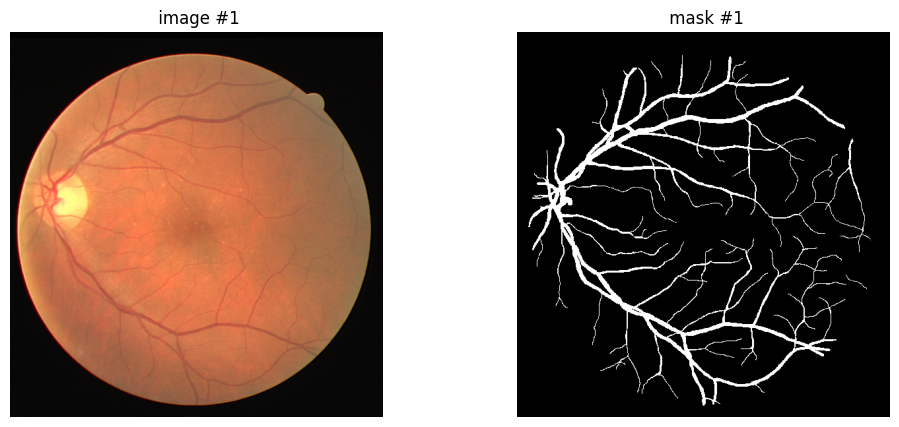

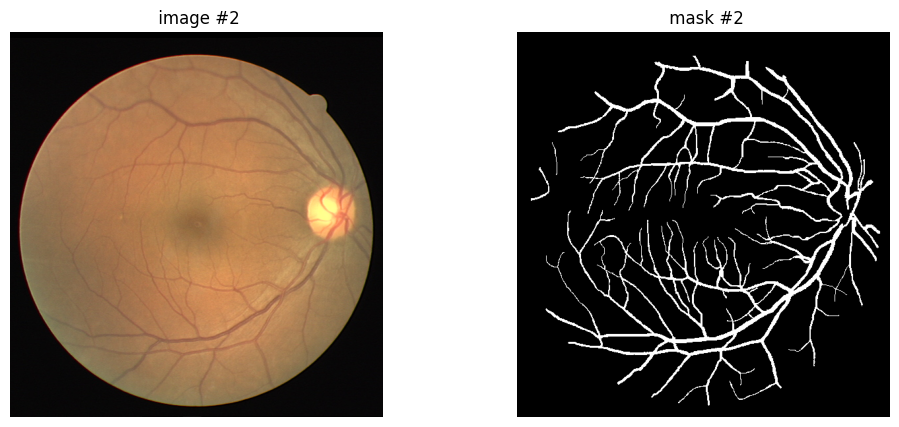

In [33]:
import matplotlib.pyplot as plt

num_samples = 2

print("Примеры изображений и масок из тестового набора")

for i in range(num_samples):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f" image #{i+1}")
    plt.imshow(X_val[i])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f" mask #{i+1}")
    plt.imshow(Y_val[i], cmap='gray')
    plt.axis('off')

    plt.show()

In [34]:
import numpy as np

class Metrics:
    def __init__(self, preds, y_true, threshold=0.5):
        self.preds = preds
        self.y_true = y_true
        self.threshold = threshold
        self.preds_bin = (preds > threshold).astype(np.float32)
        y_true_f = y_true.flatten()
        preds_f = self.preds_bin.flatten()

        self.TP = np.sum((preds_f == 1) & (y_true_f == 1))
        self.FP = np.sum((preds_f == 1) & (y_true_f == 0))
        self.TN = np.sum((preds_f == 0) & (y_true_f == 0))
        self.FN = np.sum((preds_f == 0) & (y_true_f == 1))

    def iou_score(self, eps=1e-6):
        intersection = self.TP
        union = self.TP + self.FP + self.FN
        return (intersection + eps) / (union + eps)

    def dice_score(self, eps=1e-6):
        return (2 * self.TP + eps) / (2 * self.TP + self.FP + self.FN + eps)

    def recall(self, eps=1e-6):
        return self.TP / (self.TP + self.FN + eps)

    def specificity(self, eps=1e-6):
        return self.TN / (self.TN + self.FP + eps)

    def accuracy(self, eps=1e-6):
        return (self.TP + self.TN) / (self.TP + self.TN + self.FP + self.FN + eps)

In [35]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNetPP(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        # Encoding path
        self.conv0_0 = conv_block(in_channels, 32)
        self.pool0 = nn.MaxPool2d(2)

        self.conv1_0 = conv_block(32, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2_0 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3_0 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4_0 = conv_block(256, 512)

        self.up1_0 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up2_0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up3_0 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up4_0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)

        self.conv0_1 = conv_block(32 + 32, 32)      # 64
        self.conv1_1 = conv_block(64 + 64, 64)      # 128
        self.conv2_1 = conv_block(128 + 128, 128)   # 256
        self.conv3_1 = conv_block(256 + 256, 256)   # 512

        self.conv0_2 = conv_block(32 + 32 + 32, 32)       # 96
        self.conv1_2 = conv_block(64 + 64 + 64, 64)       # 192
        self.conv2_2 = conv_block(128 + 128 + 128, 128)   # 384

        self.conv0_3 = conv_block(32 + 32 + 32 + 32, 32)  # 128
        self.conv1_3 = conv_block(64 + 64 + 64 + 64, 64)  # 256

        self.conv0_4 = conv_block(32 + 32 + 32 + 32 + 32, 32)  # 160

        self.final1 = nn.Conv2d(32, 1, kernel_size=1)
        self.final2 = nn.Conv2d(32, 1, kernel_size=1)
        self.final3 = nn.Conv2d(32, 1, kernel_size=1)
        self.final4 = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, inputs, deep_supervision=False):
        # Encoder
        x0_0 = self.conv0_0(inputs)
        down0 = self.pool0(x0_0)

        x1_0 = self.conv1_0(down0)
        down1 = self.pool1(x1_0)

        x2_0 = self.conv2_0(down1)
        down2 = self.pool2(x2_0)

        x3_0 = self.conv3_0(down2)
        down3 = self.pool3(x3_0)

        x4_0 = self.conv4_0(down3)

        x0_1 = self.conv0_1(torch.cat([x0_0, self.up1_0(x1_0)], dim=1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up2_0(x2_0)], dim=1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up3_0(x3_0)], dim=1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up4_0(x4_0)], dim=1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up1_0(x1_1)], dim=1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up2_0(x2_1)], dim=1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up3_0(x3_1)], dim=1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up1_0(x1_2)], dim=1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up2_0(x2_2)], dim=1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up1_0(x1_3)], dim=1))

        output1 = torch.sigmoid(self.final1(x0_1))
        output2 = torch.sigmoid(self.final2(x0_2))
        output3 = torch.sigmoid(self.final3(x0_3))
        output4 = torch.sigmoid(self.final4(x0_4))

        if deep_supervision:
            return [output1, output2, output3, output4]
        else:
            return output4

In [39]:
model = UNetPP()
def dice_loss_torch(pred, target, eps=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + eps) / (union + eps)
    return 1 - dice.mean()
# def train(model, optimizer, train_loader, val_loader, n_epochs, device, scheduler=None):
#     model.to(device)
#     bce_loss_fn = nn.BCELoss()

#     for epoch in range(n_epochs):
#         model.train()
#         train_loss = 0.0

#         pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}")
#         for X, y in pbar:
#             X, y = X.to(device), y.to(device)

#             optimizer.zero_grad()
#             y_pred = model(X)

#             bce = bce_loss_fn(y_pred, y)
#             dice = dice_loss_torch(y_pred, y)
#             loss = bce + dice

#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#             pbar.set_postfix({"train_loss": loss.item()})

#         train_loss /= len(train_loader)

#         # ---- Валидация ----
#         model.eval()
#         val_loss, dice_score, iou_score = 0.0, 0.0, 0.0

#         with torch.no_grad():
#             for X, y in val_loader:
#                 X, y = X.to(device), y.to(device)
#                 y_pred = model(X)

#                 bce = bce_loss_fn(y_pred, y)
#                 dice = dice_loss_torch(y_pred, y)
#                 val_loss += (bce + dice).item()

#                 # Вычисляем метрики
#                 preds_bin = (y_pred > 0.5).float()
#                 intersection = (preds_bin * y).sum()
#                 union = preds_bin.sum() + y.sum()
#                 dice_score += (2 * intersection / (union + 1e-6)).item()

#                 iou_score += (intersection / (preds_bin.sum() + y.sum() - intersection + 1e-6)).item()

#         val_loss /= len(val_loader)
#         dice_score /= len(val_loader)
#         iou_score /= len(val_loader)

#         print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, dice={dice_score:.4f}, IoU={iou_score:.4f}")

#         if scheduler:
#             scheduler.step(val_loss)
def train_deep_supervision(model, optimizer, train_loader, val_loader, n_epochs, device,
                           scheduler=None, early_stop_patience=10):
    model.to(device)
    bce_loss_fn = nn.BCELoss()

    # веса потерь для deep supervision
    loss_weights = [0.25, 0.25, 0.25, 1.0]

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}")
        for X, y in pbar:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X, deep_supervision=True)  # список из 4 выходов

            total_loss = 0
            for out, w in zip(outputs, loss_weights):
                total_loss += w * (bce_loss_fn(out, y) + dice_loss_torch(out, y))

            total_loss.backward()
            optimizer.step()
            train_loss += total_loss.item()
            pbar.set_postfix({"train_loss": total_loss.item()})

        train_loss /= len(train_loader)

        # ---- Валидация ----
        model.eval()
        val_loss, dice_score, iou_score = 0.0, 0.0, 0.0

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X, deep_supervision=True)
                out_final = outputs[-1]  # финальный выход для метрик

                # Считаем потери для всех выходов
                total_val_loss = 0
                for out, w in zip(outputs, loss_weights):
                    total_val_loss += w * (bce_loss_fn(out, y) + dice_loss_torch(out, y))
                val_loss += total_val_loss.item()

                # Метрики для финального выхода
                preds_bin = (out_final > 0.5).float()
                intersection = (preds_bin * y).sum()
                union = preds_bin.sum() + y.sum()
                dice_score += (2 * intersection / (union + 1e-6)).item()
                iou_score += (intersection / (preds_bin.sum() + y.sum() - intersection + 1e-6)).item()

        val_loss /= len(val_loader)
        dice_score /= len(val_loader)
        iou_score /= len(val_loader)

        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, dice={dice_score:.4f}, IoU={iou_score:.4f}")

        # Scheduler
        if scheduler:
            scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")  # сохраняем лучшую модель
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stop_patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                model.load_state_dict(torch.load("best_model.pth"))
                break
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
train_deep_supervision(model=model, optimizer=optimizer, train_loader=train_dataloader, val_loader=val_dataloader, n_epochs=30, device='cuda', scheduler=scheduler, early_stop_patience=10)



Epoch 1/30: 100%|██████████| 56/56 [00:12<00:00,  4.64it/s, train_loss=1.93]
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: train_loss=2.1581, val_loss=1.9023, dice=0.5978, IoU=0.4344


Epoch 2/30: 100%|██████████| 56/56 [00:12<00:00,  4.61it/s, train_loss=1.52]


Epoch 2: train_loss=1.7243, val_loss=1.5460, dice=0.7812, IoU=0.6431


Epoch 3/30: 100%|██████████| 56/56 [00:12<00:00,  4.58it/s, train_loss=1.42]


Epoch 3: train_loss=1.4993, val_loss=1.3306, dice=0.7863, IoU=0.6497


Epoch 4/30: 100%|██████████| 56/56 [00:12<00:00,  4.54it/s, train_loss=1.16]


Epoch 4: train_loss=1.3157, val_loss=1.1494, dice=0.7983, IoU=0.6658


Epoch 5/30: 100%|██████████| 56/56 [00:12<00:00,  4.49it/s, train_loss=1.09]


Epoch 5: train_loss=1.1660, val_loss=1.0136, dice=0.8050, IoU=0.6753


Epoch 6/30: 100%|██████████| 56/56 [00:12<00:00,  4.47it/s, train_loss=0.915]


Epoch 6: train_loss=1.0536, val_loss=0.9077, dice=0.8121, IoU=0.6853


Epoch 7/30: 100%|██████████| 56/56 [00:13<00:00,  4.21it/s, train_loss=0.921]


Epoch 7: train_loss=0.9685, val_loss=0.8307, dice=0.8140, IoU=0.6877


Epoch 8/30: 100%|██████████| 56/56 [00:13<00:00,  4.25it/s, train_loss=0.859]


Epoch 8: train_loss=0.8944, val_loss=0.7987, dice=0.8033, IoU=0.6731


Epoch 9/30: 100%|██████████| 56/56 [00:12<00:00,  4.32it/s, train_loss=0.803]


Epoch 9: train_loss=0.8478, val_loss=0.7586, dice=0.8109, IoU=0.6832


Epoch 10/30: 100%|██████████| 56/56 [00:12<00:00,  4.44it/s, train_loss=0.75]


Epoch 10: train_loss=0.8102, val_loss=0.7375, dice=0.8064, IoU=0.6773


Epoch 11/30: 100%|██████████| 56/56 [00:12<00:00,  4.43it/s, train_loss=0.779]


Epoch 11: train_loss=0.7817, val_loss=0.7294, dice=0.8078, IoU=0.6787


Epoch 12/30: 100%|██████████| 56/56 [00:12<00:00,  4.39it/s, train_loss=0.77]


Epoch 12: train_loss=0.7593, val_loss=0.7638, dice=0.8078, IoU=0.6792


Epoch 13/30: 100%|██████████| 56/56 [00:12<00:00,  4.43it/s, train_loss=0.757]


Epoch 13: train_loss=0.7544, val_loss=0.6637, dice=0.8163, IoU=0.6908


Epoch 14/30: 100%|██████████| 56/56 [00:12<00:00,  4.43it/s, train_loss=0.753]


Epoch 14: train_loss=0.7360, val_loss=0.6509, dice=0.8222, IoU=0.6993


Epoch 15/30: 100%|██████████| 56/56 [00:12<00:00,  4.42it/s, train_loss=0.631]


Epoch 15: train_loss=0.7231, val_loss=0.6295, dice=0.8242, IoU=0.7023


Epoch 16/30: 100%|██████████| 56/56 [00:12<00:00,  4.39it/s, train_loss=0.711]


Epoch 16: train_loss=0.7110, val_loss=0.6292, dice=0.8238, IoU=0.7021


Epoch 17/30: 100%|██████████| 56/56 [00:12<00:00,  4.43it/s, train_loss=0.638]


Epoch 17: train_loss=0.7106, val_loss=0.6738, dice=0.8110, IoU=0.6840


Epoch 18/30: 100%|██████████| 56/56 [00:12<00:00,  4.43it/s, train_loss=0.579]


Epoch 18: train_loss=0.7073, val_loss=0.6208, dice=0.8229, IoU=0.7005


Epoch 19/30: 100%|██████████| 56/56 [00:13<00:00,  4.28it/s, train_loss=0.607]


Epoch 19: train_loss=0.7022, val_loss=0.6114, dice=0.8262, IoU=0.7051


Epoch 20/30: 100%|██████████| 56/56 [00:12<00:00,  4.39it/s, train_loss=0.771]


Epoch 20: train_loss=0.6950, val_loss=0.5994, dice=0.8298, IoU=0.7105


Epoch 21/30: 100%|██████████| 56/56 [00:13<00:00,  4.24it/s, train_loss=0.668]


Epoch 21: train_loss=0.6917, val_loss=0.6189, dice=0.8214, IoU=0.6983


Epoch 22/30: 100%|██████████| 56/56 [00:12<00:00,  4.42it/s, train_loss=0.777]


Epoch 22: train_loss=0.6832, val_loss=0.5886, dice=0.8321, IoU=0.7137


Epoch 23/30: 100%|██████████| 56/56 [00:12<00:00,  4.42it/s, train_loss=0.73]


Epoch 23: train_loss=0.6825, val_loss=0.5904, dice=0.8304, IoU=0.7112


Epoch 24/30: 100%|██████████| 56/56 [00:12<00:00,  4.42it/s, train_loss=0.582]


Epoch 24: train_loss=0.6740, val_loss=0.5806, dice=0.8331, IoU=0.7153


Epoch 25/30: 100%|██████████| 56/56 [00:12<00:00,  4.42it/s, train_loss=0.582]


Epoch 25: train_loss=0.6666, val_loss=0.5960, dice=0.8265, IoU=0.7057


Epoch 26/30: 100%|██████████| 56/56 [00:13<00:00,  4.30it/s, train_loss=0.614]


Epoch 26: train_loss=0.6741, val_loss=0.5797, dice=0.8333, IoU=0.7156


Epoch 27/30: 100%|██████████| 56/56 [00:12<00:00,  4.41it/s, train_loss=0.67]


Epoch 27: train_loss=0.6661, val_loss=0.5921, dice=0.8320, IoU=0.7136


Epoch 28/30: 100%|██████████| 56/56 [00:13<00:00,  4.24it/s, train_loss=0.665]


Epoch 28: train_loss=0.6609, val_loss=0.5780, dice=0.8328, IoU=0.7148


Epoch 29/30: 100%|██████████| 56/56 [00:12<00:00,  4.42it/s, train_loss=0.606]


Epoch 29: train_loss=0.6574, val_loss=0.5834, dice=0.8310, IoU=0.7124


Epoch 30/30: 100%|██████████| 56/56 [00:12<00:00,  4.42it/s, train_loss=0.667]


Epoch 30: train_loss=0.6648, val_loss=0.5794, dice=0.8322, IoU=0.7141


In [66]:
print("Total parameters:", sum(p.numel() for p in model.parameters()))

Total parameters: 8828036
Trainable parameters: 8828036


In [63]:
import numpy as np
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from tqdm import tqdm

def evaluate_full_images(model, dataset, device):
    model.load_state_dict(torch.load("best_model.pth"))
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)

    all_pred_patches = []
    all_true_masks = []
    all_fov_masks = []

    with torch.no_grad():
        for imgs, masks, fovs in tqdm(dataloader):
            imgs = imgs.to(device)
            preds = model(imgs)
            all_pred_patches.append(preds.cpu().numpy().squeeze(1))
            all_true_masks.append(masks.cpu().numpy().squeeze(1))
            all_fov_masks.append(fovs.cpu().numpy().squeeze(1))

    all_pred_patches_np = np.concatenate(all_pred_patches)
    all_true_masks_np = np.concatenate(all_true_masks)
    all_fov_masks_np = np.concatenate(all_fov_masks)

    all_metrics = []
    patch_idx_start = 0

    for i in range(len(dataset.full_image_shapes)):
        num_patches = dataset.patches_per_image[i]
        shape = dataset.full_image_shapes[i]
        patch_idx_end = patch_idx_start + num_patches

        pred_patches_for_img = all_pred_patches_np[patch_idx_start:patch_idx_end]
        true_patches_for_img = all_true_masks_np[patch_idx_start:patch_idx_end]
        fov_patches_for_img = all_fov_masks_np[patch_idx_start:patch_idx_end]

        patch_idx_start = patch_idx_end

        pred_mask_full = reconstruct_from_patches(pred_patches_for_img, shape, stride=64)
        true_mask_full = reconstruct_from_patches(true_patches_for_img, shape, stride=64)
        fov_mask_full = reconstruct_from_patches(fov_patches_for_img, shape, stride=64)

        pred_mask_final = (pred_mask_full > 0.5).astype(np.float32) * (fov_mask_full > 0.5)
        true_mask_final = (true_mask_full > 0.5).astype(np.float32) * (fov_mask_full > 0.5)

        all_metrics.append(Metrics(pred_mask_final, true_mask_final))

    print(f"Dice coefficient: {np.mean([m.dice_score() for m in all_metrics]):.4f}")
    print(f"IoU:               {np.mean([m.iou_score() for m in all_metrics]):.4f}")
    print(f"Accuracy:          {np.mean([m.accuracy() for m in all_metrics]):.4f}")
    print(f"Sensitivity:       {np.mean([m.recall() for m in all_metrics]):.4f}")
    print(f"Specificity:       {np.mean([m.specificity() for m in all_metrics]):.4f}")

evaluate_full_images(model, val_dataset, device='cuda')


Получение предсказаний для всех патчей...


100%|██████████| 14/14 [00:01<00:00, 11.81it/s]



Сборка 4 полных изображений и подсчет метрик...

--- Финальный отчет (на полных изображениях) ---
Dice coefficient: 0.8327
IoU:               0.7137
Accuracy:          0.9716
Sensitivity:       0.8123
Specificity:       0.9873



Отрисовка 3 полных предсказаний...


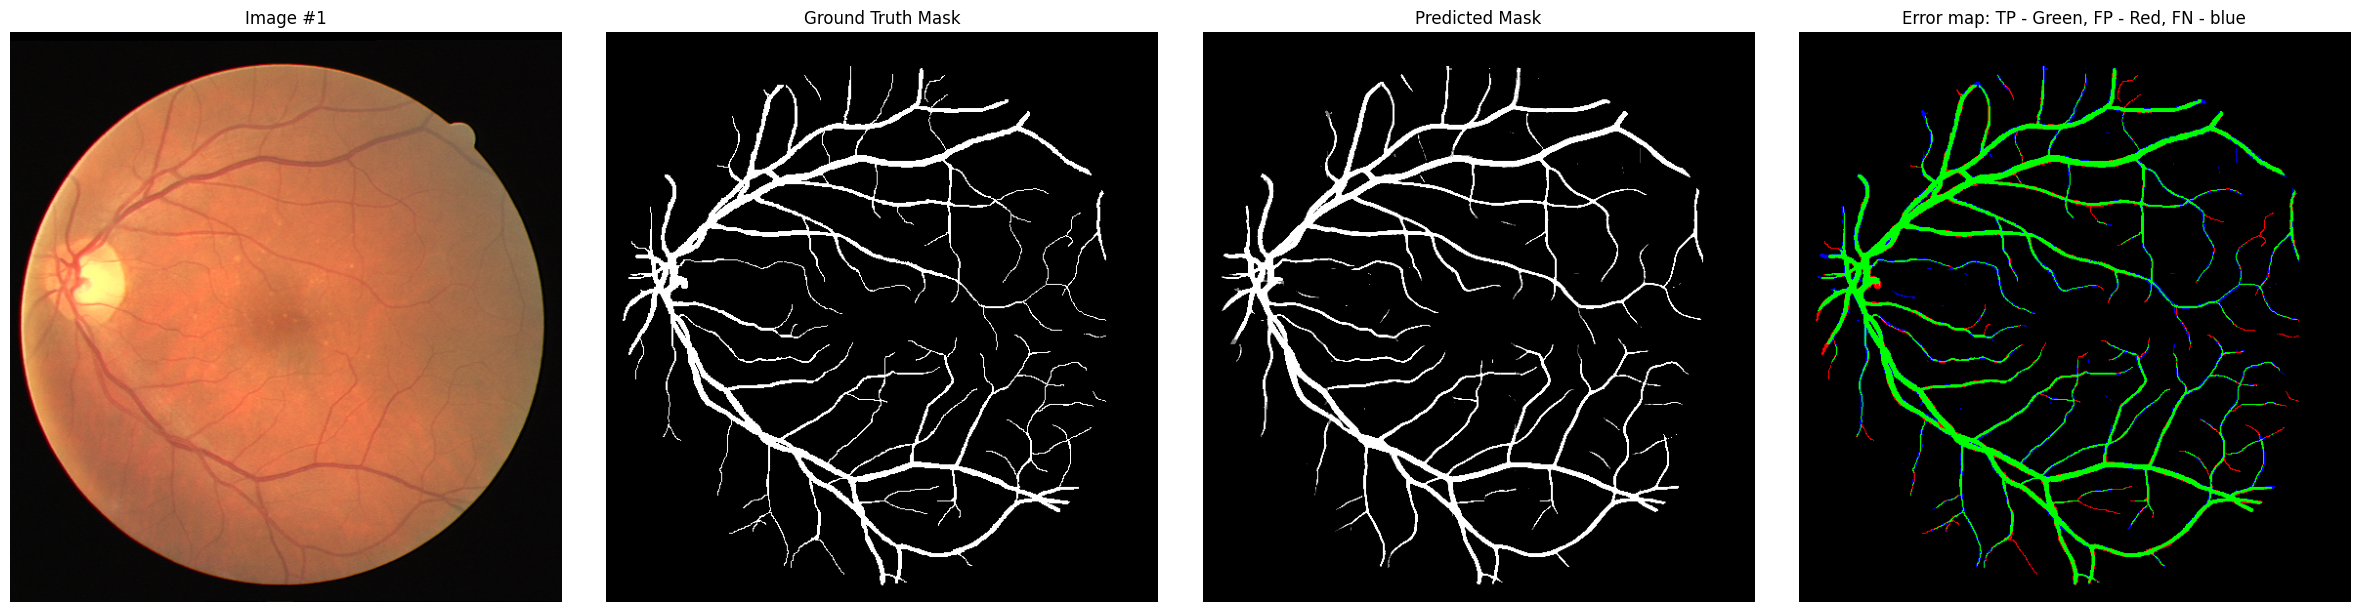

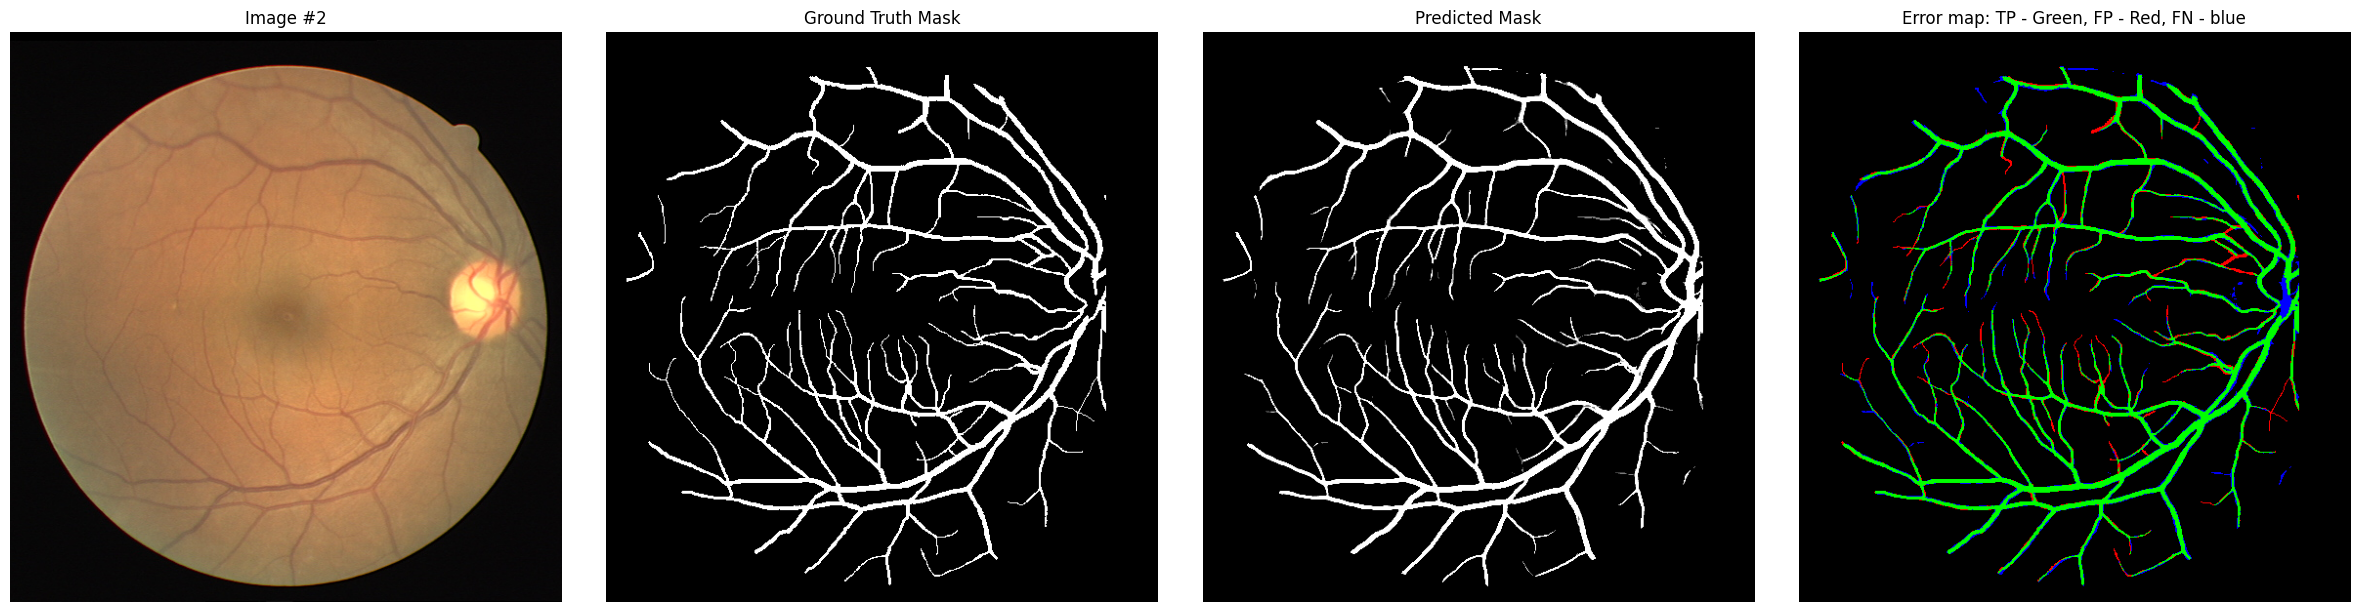

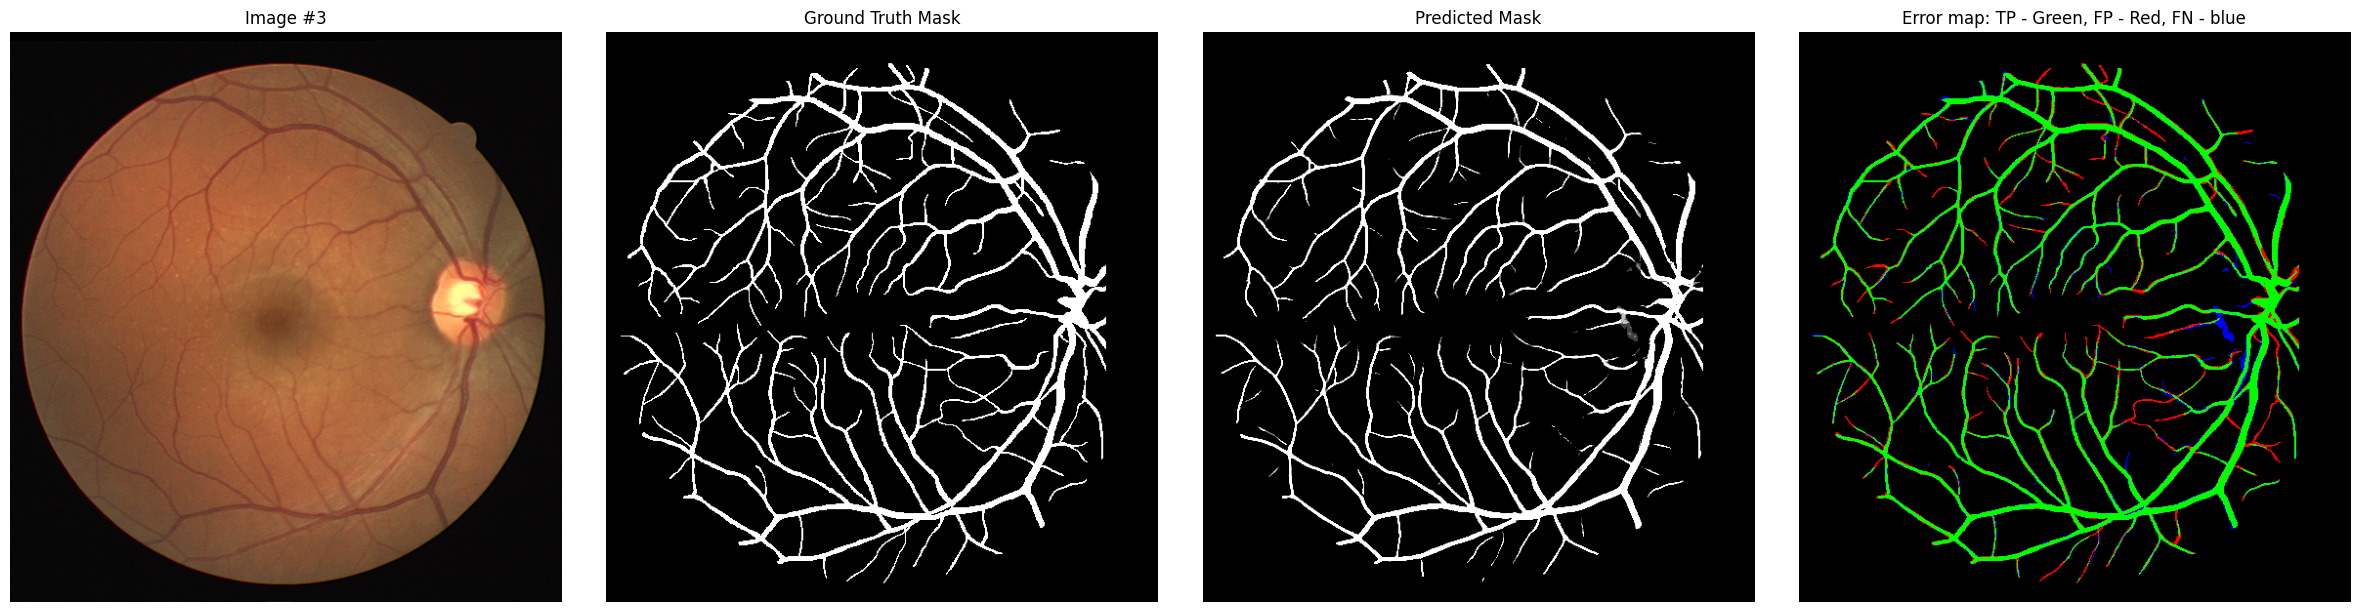

In [65]:
import matplotlib.pyplot as plt

def create_error_map(true_mask, pred_mask):
    true_mask = np.squeeze(true_mask)
    pred_mask = np.squeeze(pred_mask)

    # Приводим к бинарному виду (0/1)
    true_mask = (true_mask > 0).astype(np.uint8)
    pred_mask = (pred_mask > 0).astype(np.uint8)

    error_map = np.zeros((*true_mask.shape, 3), dtype=np.uint8)

    tp = (true_mask == 1) & (pred_mask == 1)
    fp = (true_mask == 0) & (pred_mask == 1)
    fn = (true_mask == 1) & (pred_mask == 0)

    error_map[tp] = [0, 255, 0]   # Зелёный — TP
    error_map[fp] = [255, 0, 0]   # Красный — FP
    error_map[fn] = [0, 0, 255]   # Синий — FN
    return error_map

def plot_full_predictions(model, dataset, full_imgs_np, full_fovs_np, device, num_samples=3):
    """
    Отрисовывает num_samples полных изображений, их истинные маски и предсказания.
    dataset: инстанс val_dataset
    full_imgs_np: X_val (для показа оригинальных картинок)
    full_fovs_np: fov_val (для применения маски)
    """

    model.load_state_dict(torch.load("best_model.pth"))
    model.to(device)
    model.eval()

    transform = A.Compose([ToTensorV2()])

    num_samples = min(num_samples, len(full_imgs_np))
    print(f"\nОтрисовка {num_samples} полных предсказаний...")

    for i in range(num_samples):
        img_full = full_imgs_np[i]

        mask_full = dataset.get_full_mask(i)

        fov_full = full_fovs_np[i]
        shape = img_full.shape[:2]
        patch_size = 128
        stride = 64

        patches_list = []
        for y in range(0, shape[0] - patch_size + 1, stride):
            for x in range(0, shape[1] - patch_size + 1, stride):
                img_patch = img_full[y:y+patch_size, x:x+patch_size]
                img_patch_tensor = transform(image=img_patch)['image']
                patches_list.append(img_patch_tensor)

        patches_tensor = torch.stack(patches_list).to(device)

        pred_patches_list = []
        with torch.no_grad():
            for j in range(0, len(patches_tensor), 16):
                batch = patches_tensor[j:j+16]
                pred_batch = model(batch)
                pred_batch_bin = (pred_batch > 0.5).float()

                pred_patches_list.append(pred_batch_bin.cpu().numpy().squeeze(1))

        pred_patches_np = np.concatenate(pred_patches_list)

        pred_mask_full = reconstruct_from_patches(pred_patches_np, shape, stride=64)

        pred_mask_plot = pred_mask_full * fov_full
        mask_full_plot = mask_full * fov_full
        error_map = create_error_map(pred_mask_plot, mask_full_plot)
        plt.figure(figsize=(24, 6))

        plt.subplot(1, 4, 1)
        plt.title(f"Image #{i+1}")
        plt.imshow(img_full)
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask_full_plot.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask_plot.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title("Error map: TP - Green, FP - Red, FN - blue")
        plt.imshow(error_map, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

plot_full_predictions(model, val_dataset, X_val, fov_val, device='cuda', num_samples=3)